# Capstone Project
## Image classifier for the SVHN dataset
### Instructions


In [ ]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
_ Retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Let's check dictionaries keys
print(train.keys())
print(test.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [ ]:
# Let's check dictionaries keys type
print(type(train['__header__']), type(train['__version__']), type(train['__version__']), type(train['X']), type(train['y']))
print(type(test['__header__']), type(test['__version__']), type(test['__version__']), type(test['X']), type(test['y']))

<class 'bytes'> <class 'str'> <class 'str'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'bytes'> <class 'str'> <class 'str'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


#### Let's extract the training and testing images and labels separately from the dictionaries.

In [ ]:
# Training images
X_train = train['X']
y_train = train['y']

# Testing images
X_test = test['X']
y_test = test['y']

In [ ]:
# Before moving on, let's check for the shape of all of them
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(32, 32, 3, 73257) (32, 32, 3, 26032)
(73257, 1) (26032, 1)


In [ ]:
# Let's check for the unique train labels
num_uniq_train = np.unique(y_train)
num_uniq_train

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

#### Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
# For features array, let's move last axis to first position keeping the others in place so that Tensorflow 2 can access via: samples, image size and colors.
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1 , 0)

In [ ]:
# Let's check for the shape 
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(73257, 32, 32, 3) (26032, 32, 32, 3)
(73257, 1) (26032, 1)


In [ ]:
# Let's define a function
def rand_sample_imgs(sample_imgs, range_size, figsize_h, figsize_v):
    """ This function displays a random number of images in a single row.
    Parameters:
    - sample_imgs: amount of images to be displayed,
    - range_zie: size of the range of the set of imges from which to select them in 
    a random way.
    """
    random_img_id = random.sample(range(0, range_size), sample_imgs)
    fig_rows = 1
    fig_columns = sample_imgs

    fig, ax = plt.subplots(fig_rows, fig_columns, figsize=(figsize_h, figsize_v))
    for i in range(sample_imgs):
        ax[i].imshow(X_train[random_img_id[i]])
        ax[i].set_title('label ' + str(y_train[random_img_id[i]]), loc='center')

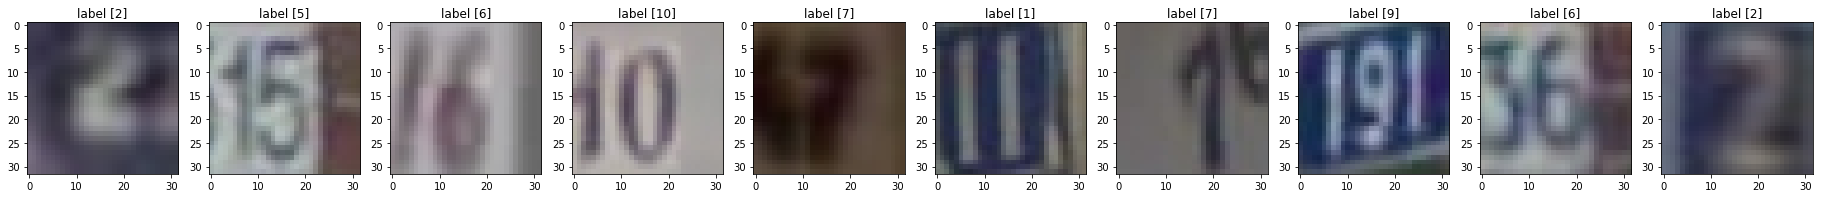

In [ ]:
rand_sample_imgs(10, X_train.shape[0], X_train.shape[1], X_train.shape[2])

#### Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
_Hint: retain the channel dimension, which will now have size 1.
#### Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
# Let's define another function
def rand_sample_imgs_grayscale(sample_imgs, range_size, figsize_h, figsize_v, cmap):
    """ This function displays a random number of images in a single row.
    Parameters:
    - sample_imgs: amount of images to be displayed,
    - range_zie: size of the range of the set of imges from which to select them in 
    a random way,
    - cmap: matplotlib built-in colormap.
    """
    random_img_id = random.sample(range(0, range_size), sample_imgs)
    fig_rows = 1
    fig_columns = sample_imgs

    fig, ax = plt.subplots(fig_rows, fig_columns, figsize=(figsize_h, figsize_v))
    for i in range(sample_imgs):
        ax[i].imshow(X_train[random_img_id[i], :, :, 0], cmap=cmap)
        ax[i].set_title('label ' + str(y_train[random_img_id[i]]), loc='center')

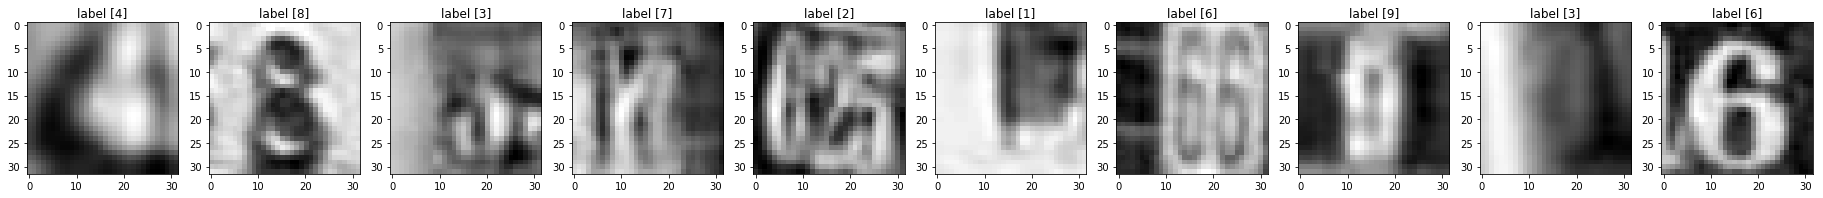

In [ ]:
rand_sample_imgs_grayscale(10, X_train.shape[0], X_train.shape[1], X_train.shape[2], 'gray')

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. The model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* Design and build the model. Experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy it is not needed to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (a maximum of 30 epochs is recommended), making use of both training and validation sets during the training run. 
* The model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
# Let's check for the train max and min values to assess need of scaling
X_train_max = np.ndarray.max(X_train)
print(X_train_max)
X_train_min = np.ndarray.min(X_train)
print(X_train_min)

255
0


In [ ]:
# Let's preprocess training data for better performance during training
def scale_data(X_train, X_test):
    """
    This function takes in the training and test data as loaded above, and scales them
    so that they have minimum and maximum values equal to 0 and 1 respectively.
    """
    return (X_train/float(np.ndarray.max(X_train)), X_test/float(np.ndarray.max(X_test)))

In [ ]:
X_train, X_test = scale_data(X_train, X_test)

In [ ]:
# Let's check again for the train max and min values 
X_train_max = np.ndarray.max(X_train)
print(X_train_max)
X_train_min = np.ndarray.min(X_train)
print(X_train_min)

1.0
0.0


In [ ]:
# Let's define a function for the model creation
def mlp_build(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(216, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    return model

In [ ]:
model = mlp_build(X_train[0].shape)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 216)               110808    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                13888     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 1,698,722
Trainable params: 1,698,722
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Let's define a method for model compilation
def mlp_compile(model, learning_rate):
    """
    This function takes in a model and compiles it with:
    - optimiser: Adam optimiser with learning rate set to 0.0001,
    - loss: uses the categorical crossentropy loss function, and 
    - metric: accuracy as the only metric. 
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

In [ ]:
mlp_compile(model, learning_rate=0.0001)

In [ ]:
# Let's define a function for model training
def mlp_train(model, X_train, y_train, epochs):
    """
    This function:
    - trains a model,
    - for a given number of epochs,
    - on the  train_data and train_targets, 
    - sets the validation data to be 20% of the training data,
    - uses an EarlyStopping callback that stops training when the validation (testing) accuracy has not improved in the last 3 epochs, and
    - uses a ModelCheckpoint object that:
       * saves only the weights that generate the highest validation (testing) accuracy,
       * saves into a directory called 'checkpoints_best_only' inside the current working directory, and
       * generates a file called 'checkpoints_best_only/checkpoint.
    """
    history = model.fit(
        X_train,
        y_train,
        epochs = epochs,
        validation_split=0.20,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_accuracy'),
            ModelCheckpoint(
                filepath = 'checkpoints_best_only/checkpoint',
                frequency='epoch',
                save_best_only=True,
                monitor='val_accuracy',
                save_weights_only=True, 
                verbose=1)
            ],
        batch_size = 64,
        verbose = 2
    )
    
    return history

In [ ]:
# To prevent labels value to fall outside the valid range [0, 10).
y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

In [ ]:
num_uniq_train = np.unique(y_train)
num_uniq_train

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
history = mlp_train(model, 
                    X_train, 
                    y_train, 
                    epochs=30)

Train on 58605 samples, validate on 14652 samples
Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.42806, saving model to checkpoints_best_only/checkpoint
58605/58605 - 85s - loss: 2.0896 - accuracy: 0.2547 - val_loss: 1.7556 - val_accuracy: 0.4281
Epoch 2/30

Epoch 00002: val_accuracy improved from 0.42806 to 0.54293, saving model to checkpoints_best_only/checkpoint
58605/58605 - 76s - loss: 1.5133 - accuracy: 0.5087 - val_loss: 1.4165 - val_accuracy: 0.5429
Epoch 3/30

Epoch 00003: val_accuracy improved from 0.54293 to 0.62305, saving model to checkpoints_best_only/checkpoint
58605/58605 - 75s - loss: 1.2600 - accuracy: 0.6123 - val_loss: 1.2176 - val_accuracy: 0.6231
Epoch 4/30

Epoch 00004: val_accuracy improved from 0.62305 to 0.65998, saving model to checkpoints_best_only/checkpoint
58605/58605 - 76s - loss: 1.1364 - accuracy: 0.6528 - val_loss: 1.1213 - val_accuracy: 0.6600
Epoch 5/30

Epoch 00005: val_accuracy improved from 0.65998 to 0.68189, saving model to check

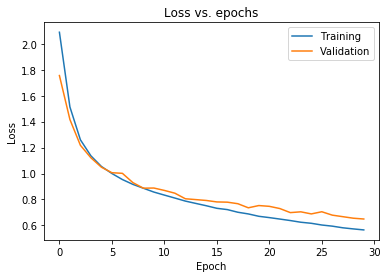

In [ ]:
# Let's plot the learning curves for loss vs epoch for both training and validation sets.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

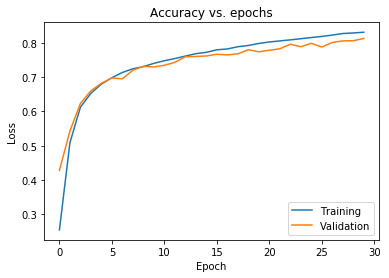

In [ ]:
# Let's plot accuracy vs epoch for both training and validation sets.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. The model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* Design and build the model. Experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy it is not needed to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* Aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
# Let's define a function for the CNN classifier
def cnn_classifier(input_shape, dropout_rate, weight_decay):
    model = Sequential([
        Conv2D(16, kernel_size=3, activation='relu', input_shape=X_train[0].shape),
        MaxPool2D(pool_size=(3,3), strides=1),
        Conv2D(32, kernel_size = 3, strides=1, activation='relu'),
        MaxPool2D(pool_size=(1,1), strides=3),
        BatchNormalization(),
        Dropout(dropout_rate),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    
    return model

In [ ]:
model = cnn_classifier(X_train[0].shape, dropout_rate=0.3, weight_decay=0.001)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)             

In [ ]:
# Let's define a method for model compilation
def cnn_compile(model, learning_rate):
    """
    This function takes in a model and compiles it with:
    - optimiser: Adam optimiser with learning rate set to 0.0001,
    - loss: uses the categorical crossentropy loss function, and 
    - metric: accuracy as the only metric. 
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

In [ ]:
cnn_compile(model, learning_rate=0.0001)

In [ ]:
# Let's define a function for model training
def cnn_train(model, X_train, y_train, epochs):
    """
    This function:
    - trains a model,
    - for a given number of epochs,
    - on the  train_data and train_targets, 
    - sets the validation data to be 20% of the training data,
    - uses an EarlyStopping callback that stops training when the validation (testing) accuracy has not improved in the last 3 epochs, and
    - uses a ModelCheckpoint object that:
       * saves only the weights that generate the highest validation (testing) accuracy,
       * saves into a directory called 'checkpoints_best_only' inside the current working directory, and
       * generates a file called 'checkpoints_best_only/checkpoint.
    """
    history = model.fit(
        X_train,
        y_train,
        epochs = epochs,
        validation_split=0.20,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_accuracy'),
            ModelCheckpoint(
                filepath = 'cnn_checkpoints_best_only/checkpoint',
                frequency='epoch',
                save_best_only=True,
                monitor='val_accuracy',
                save_weights_only=True, 
                verbose=1)
            ],
        batch_size = 64,
        verbose = 2
    )
    
    return history

In [ ]:
history = cnn_train(model, X_train, y_train, epochs=30)

Train on 58605 samples, validate on 14652 samples
Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.78672, saving model to cnn_checkpoints_best_only/checkpoint
58605/58605 - 465s - loss: 1.6391 - accuracy: 0.4405 - val_loss: 0.7641 - val_accuracy: 0.7867
Epoch 2/30

Epoch 00002: val_accuracy improved from 0.78672 to 0.84480, saving model to cnn_checkpoints_best_only/checkpoint
58605/58605 - 438s - loss: 0.7117 - accuracy: 0.7794 - val_loss: 0.5188 - val_accuracy: 0.8448
Epoch 3/30

Epoch 00003: val_accuracy improved from 0.84480 to 0.85831, saving model to cnn_checkpoints_best_only/checkpoint
58605/58605 - 441s - loss: 0.5595 - accuracy: 0.8291 - val_loss: 0.4700 - val_accuracy: 0.8583
Epoch 4/30

Epoch 00004: val_accuracy improved from 0.85831 to 0.86555, saving model to cnn_checkpoints_best_only/checkpoint
58605/58605 - 432s - loss: 0.4943 - accuracy: 0.8485 - val_loss: 0.4575 - val_accuracy: 0.8655
Epoch 5/30

Epoch 00005: val_accuracy improved from 0.86555 to 0.87974, s

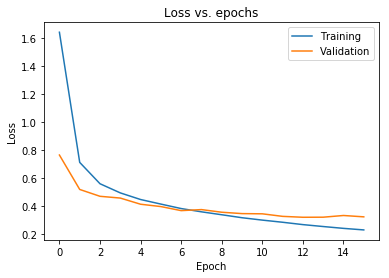

In [ ]:
# Let's plot the learning curves for loss vs epoch for both training and validation sets.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

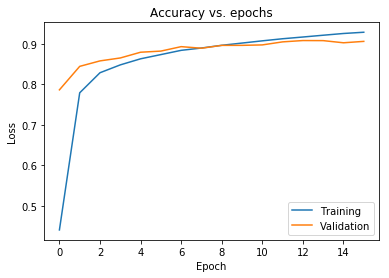

In [ ]:
# Let's plot accuracy vs epoch for both training and validation sets.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
best_MLP = mlp_build(X_train[0].shape)
best_MLP.load_weights('checkpoints_best_only/checkpoint')

In [ ]:
best_CNN = cnn_classifier(X_train[0].shape, dropout_rate=0.3, weight_decay=0.001)
best_CNN.load_weights('cnn_checkpoints_best_only/checkpoint')

In [ ]:
def show_predictive_distribution(model):

    num_test_images = X_test.shape[0]

    random_inx = np.random.choice(num_test_images, 5)
    random_test_images = X_test[random_inx, ...]
    random_test_labels = y_test[random_inx, ...]

    predictions = model.predict(random_test_images)

    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        axes[i, 1].bar(np.arange(len(prediction)), prediction)
        axes[i, 1].set_xticks(np.arange(len(prediction)))
        axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
    plt.show()

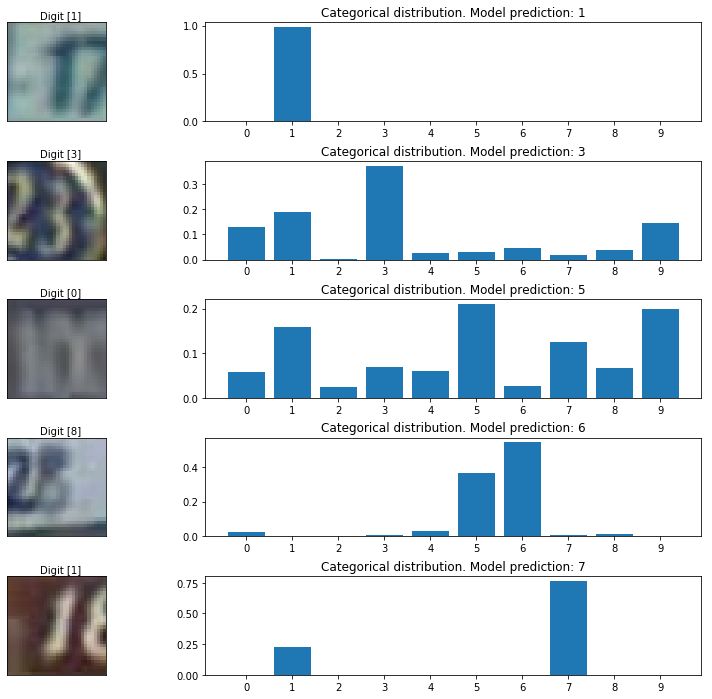

In [ ]:
show_predictive_distribution(best_MLP)

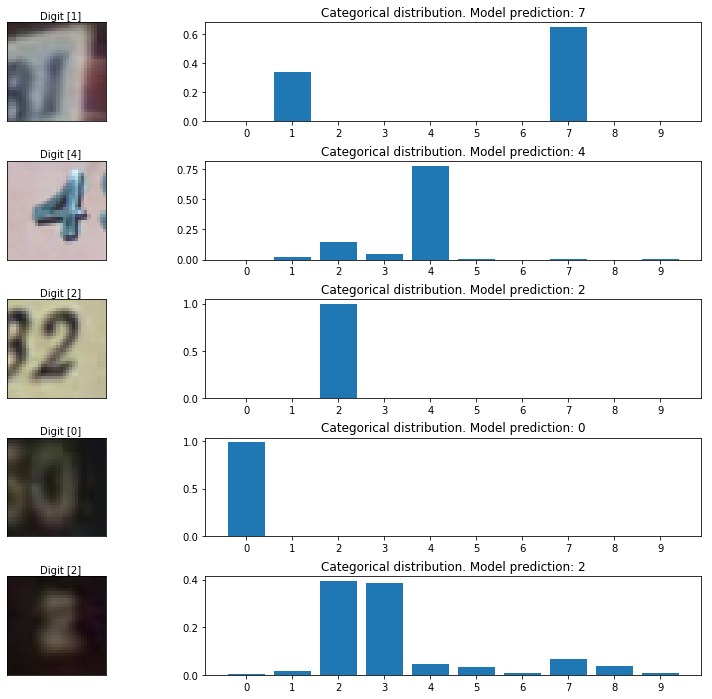

In [ ]:
show_predictive_distribution(best_CNN)